In [1]:
#Data processing
import pandas as pd 
#Data manipulation
import numpy as np 
from numpy import array

#Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Spark libraries
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql import SQLContext

#A Machine Learning library
import sklearn

## 1. Data Acquisition

In [2]:
sqlContext = SQLContext(sc)
raw_data = sqlContext.read.load('file:///home/cloudera/Documents/PetProject/SourceData/assessment_data.csv', 
                          format='com.databricks.spark.csv', 
                            header='true',inferSchema='true') 

In [3]:
#Checking if the data loaded successfully and inspecting the total number of rows
no_of_rows = raw_data.count()  
print('Number of rows:', no_of_rows)

Number of rows: 1309


The data frame is not empty, since it is able to return row count

In [4]:
#Total number of columns
no_of_columns = len(raw_data.columns)
print('Number of columns:', no_of_columns)

Number of columns: 10


## 2. Calculating Memory Requirement

In [5]:
#Calculating total number of bytes required
a = no_of_rows * no_of_columns * 8 #1309 Rows * 10 Columns * 8 bytes
print(a, 'bytes')

104720 bytes


In [6]:
#Converting bytes to megabytes
print (a / 2 ** 20,'MB') #bytes/MB

0.0998687744140625 MB


The rule of thumb suggests that we are going to need twice the memory (0.0999 MB *2) to read the dataset. Our machine has 4gb of memory, we are confident that our machine can handle the data load, thus we can proceed with the data exploration

## 3. Data Exploration

In [7]:
#Print the dataframe schema
raw_data.printSchema()

root
 |-- target_var: integer (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: integer (nullable = true)
 |-- feature_3: integer (nullable = true)
 |-- feature_4: string (nullable = true)
 |-- feature_5: string (nullable = true)
 |-- feature_6: double (nullable = true)
 |-- feature_7: integer (nullable = true)
 |-- feature_8: string (nullable = true)
 |-- feature_9: double (nullable = true)



The target variable is an integer. None of the columns are empty. We have three data types, integer, double and string

In [8]:
# Summary statistics
raw_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
target_var,1309,0.3819709702062643,0.48605517086648325,0,1
feature_1,1308,33.29547928134572,51.75866823917421,0.0,512.3292
feature_2,1309,0.3850267379679144,0.8655602753495143,0,9
feature_3,1309,0.4988540870893812,1.0416583905961012,0,8
feature_6,1046,29.8811345124283,14.413499699923596,0.1667,80.0
feature_7,1309,2.294881588999236,0.8378360189701272,1,3
feature_9,1309,101.79412006638843,50.890853273921955,-93.97433274233103,264.6922898178428


In [9]:
#Displaying the first five rows
raw_data.show(5)

+----------+---------+---------+---------+----------+---------+---------+---------+---------+------------------+
|target_var|feature_1|feature_2|feature_3| feature_4|feature_5|feature_6|feature_7|feature_8|         feature_9|
+----------+---------+---------+---------+----------+---------+---------+---------+---------+------------------+
|         1| 211.3375|        0|        0|bigollo-16|     blue|     29.0|        1|    sigma|112.87794148245936|
|         1|   151.55|        2|        1| cantor-33|     pink|   0.9167|        1|    sigma|60.291423340617406|
|         0|   151.55|        2|        1| cantor-33|     blue|      2.0|        1|    sigma|143.79410265574725|
|         0|   151.55|        2|        1| cantor-33|     pink|     30.0|        1|    sigma|   131.27835242517|
|         0|   151.55|        2|        1| cantor-33|     blue|     25.0|        1|    sigma|204.41571605575584|
+----------+---------+---------+---------+----------+---------+---------+---------+---------+---

In [10]:
#Print count of distinct values for all variables
print('target_var:',raw_data.select('target_var').distinct().count())
print('feature_1:',raw_data.select('feature_1').distinct().count())
print('feature_2:',raw_data.select('feature_2').distinct().count())
print('feature_3:',raw_data.select('feature_3').distinct().count())
print('feature_4:',raw_data.select('feature_4').distinct().count())
print('feature_5:',raw_data.select('feature_5').distinct().count())
print('feature_6:',raw_data.select('feature_6').distinct().count())
print('feature_7:',raw_data.select('feature_7').distinct().count())
print('feature_8:',raw_data.select('feature_8').distinct().count())
print('feature_9:',raw_data.select('feature_9').distinct().count())

target_var: 2
feature_1: 282
feature_2: 8
feature_3: 7
feature_4: 182
feature_5: 2
feature_6: 99
feature_7: 3
feature_8: 4
feature_9: 1309


In [11]:
#Showing the distinct variables for each variable
raw_data.select('target_var').distinct().show()
raw_data.select('feature_2').distinct().show()
raw_data.select('feature_3').distinct().show()
raw_data.select('feature_5').distinct().show()
raw_data.select('feature_7').distinct().show()
raw_data.select('feature_8').distinct().show()

+----------+
|target_var|
+----------+
|         0|
|         1|
+----------+

+---------+
|feature_2|
+---------+
|        0|
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        9|
+---------+

+---------+
|feature_3|
+---------+
|        0|
|        1|
|        2|
|        3|
|        4|
|        5|
|        8|
+---------+

+---------+
|feature_5|
+---------+
|     pink|
|     blue|
+---------+

+---------+
|feature_7|
+---------+
|        1|
|        2|
|        3|
+---------+

+---------+
|feature_8|
+---------+
|     qoph|
|    gamma|
|    sigma|
|         |
+---------+



In [12]:
#Switching to pandas dataframe to utilise the visualation packages
pandasDF = raw_data.toPandas()

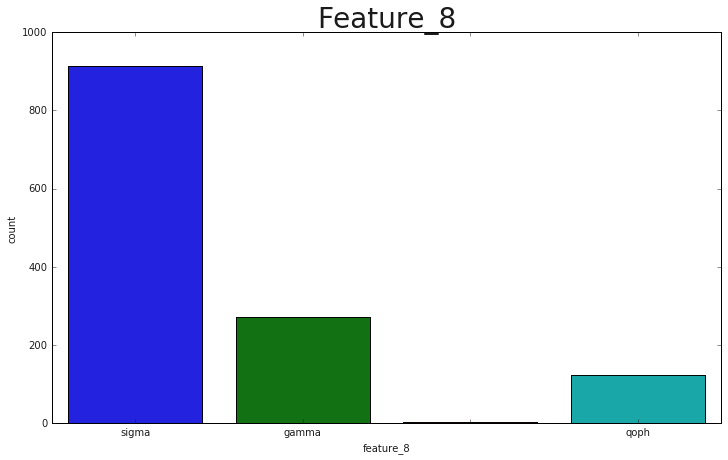

In [13]:
g=sns.countplot(x= 'feature_8',data = pandasDF, alpha=0.90)
g=sns.countplot(x= 'feature_8',data = pandasDF, alpha=0.90)
sns.set_color_codes("muted")
g.figure.set_size_inches(12,7)
g.axes.set_title('Feature_8', fontsize = 28)

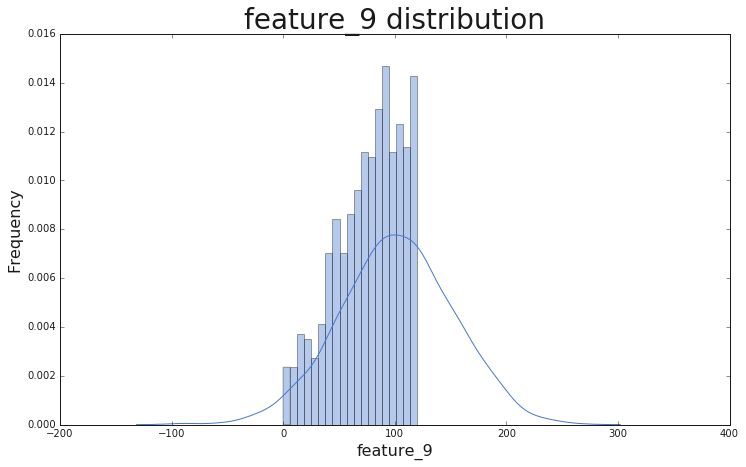

In [14]:
#Histogram distribution to inspect the presence of outliers
bins = np.linspace(0, 120, 20)
hist = sns.distplot(pandasDF.feature_9, bins=bins)
sns.set_color_codes("muted")
hist.set_xlabel('feature_9', size = 16)
hist.set_ylabel('Frequency', size = 16)
hist.figure.set_size_inches(12,7)
hist.axes.set_title('feature_9 distribution', fontsize = 28)

As per the histogram distribution above there are no outliers

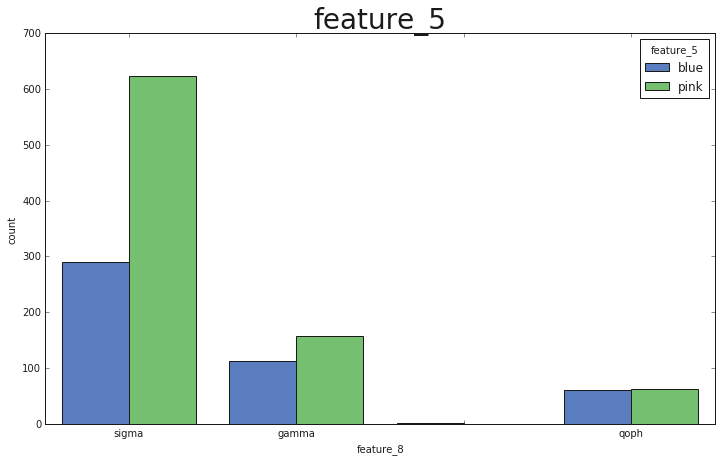

In [15]:
gbarplt= sns.countplot(x= 'feature_8', hue = 'feature_5', data = pandasDF)
sns.set_color_codes("muted")
gbarplt.figure.set_size_inches(12,7)
gbarplt.axes.set_title('feature_5', fontsize = 28)

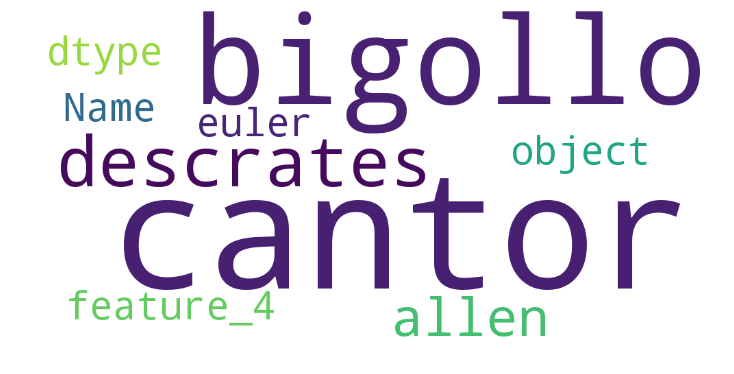

In [16]:
#Which hospital had most appointments
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 500, collocations=True, random_state=42).generate(str(pandasDF['feature_4']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

The word cantor occured the most in variabe feature_4. However, this is not calculating accurately, further calculations are needed to get it working.

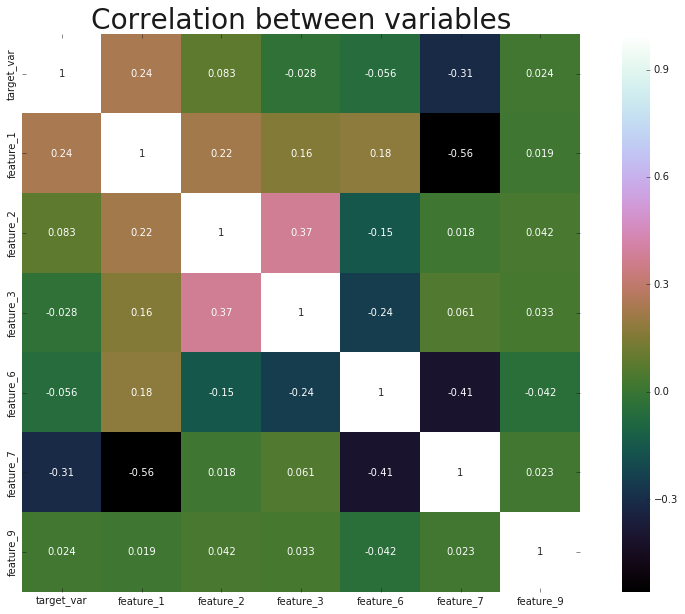

In [17]:
#Relationship between variables
correlation = pandasDF.corr()
plt.figure(figsize = (10,10))
corr = sns.heatmap(correlation, vmax=1, square=True, annot=True,cmap='cubehelix')
corr.figure.set_size_inches(15,10)
plt.title("Correlation between variables", size = 28)

Overall this problem does not present us with highly correlated variables. We will keep all variables for model building

### Data Validation

In [18]:
#Showing count of missing values for each variable
raw_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in raw_data.columns]).show()

+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|target_var|feature_1|feature_2|feature_3|feature_4|feature_5|feature_6|feature_7|feature_8|feature_9|
+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|         0|        1|        0|        0|        0|        0|      263|        0|        0|        0|
+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+



## 4.Pre-Process

### 4.1 Imputing missing values

Since we cannot make any assumptions with the underlying data source or do no have the domain knowledge, we will opt to drop the missing values as oppossesd to imputing them with either the mean, mode, median, logistic regression or linear regression where applicable.

### 4.2 Removing missing values

In [19]:
#dropping missing values
clean_data = raw_data.na.drop()

We can see that the number of rows has now reduced from 1309  to 1045

In [20]:
# Veryfying if missing values where removed successfully
clean_data.count()

1045

In [21]:
#Preparing the model building data using pandas
mb = clean_data.toPandas()

# 5. Model Building

## 5.1 Naive Bayes (NB)

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

#### 5.1.1 Organizing DataSets

In [23]:
# Label encoder
le = preprocessing.LabelEncoder()

for i in range(0,mb.shape[1]):
    if mb.dtypes[i]=='object':
        mb[mb.columns[i]] = le.fit_transform(mb[mb.columns[i]])

In [24]:
#Split the data into training and test sets
X = mb.ix[:,(1,2,3,4,5,6,7,8,9)]
y = mb.ix[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42) 

In [25]:
# Initialize our classifier
gnb = GaussianNB()
# Train our classifier
model = gnb.fit(X_train, y_train)

### 5.1.2 Building and Evaluating the Model

In [26]:
# Make predictions
target_var_pred = gnb.predict(X_test)
print(target_var_pred)

[0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1
 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0
 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0
 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1
 1 1 1]


In [27]:
# Place the predictions of the test data in a Pandas data frame
nb_df_with_answers = pd.DataFrame({'target_var_pred': target_var_pred, 'target_var_true':y_test.values})

In [28]:
# Sanity check
nb_df_with_answers.head()

,target_var_pred,target_var_true
0,0,1
1,1,1
2,0,0
3,0,0
4,1,1


In [29]:
# Now get indexes for the all predictions made 
# Only the ones that cost the company a lot of money
# Get the incorrect ones versus the correct predictions

nb_df_with_answers_ = nb_df_with_answers.copy()
no_loss = []
loss_R1000 = []
loss_R20000 = []
index_1 = []
index_2 = [] 
index_3 = [] 

# loop over all test indices
for i in range(len(y_test.values)):
    # This loops over all predictions that are "Correct"
    if int(nb_df_with_answers_.target_var_true[i]) == int(nb_df_with_answers_.target_var_pred[i]):
            no_loss.append("no_loss") 
            index_1.append(i)
    
    # This following "else if" and else loop over all predictions that are "Incorrect"        
    elif int(nb_df_with_answers_.target_var_true[i]) == 1 and int(nb_df_with_answers_.target_var_pred[i]) == 0:
            loss_R20000.append("lost_R20000") 
            index_2.append(i) 
    else:
            loss_R1000.append("lost_R1000") 
            index_3.append(i)
# Save corresponding indices to placeholder arrays            
index_1 = np.array(index_1)
index_2 = np.array(index_2)
index_3 = np.array(index_3)

In [30]:
# Create a placeholder for the types of predictions made
# in terms of string format, the way it defined allows saving strings of different lengths
# in respective rows/entries. 
arr = np.array(np.zeros(len(y_test.values)), str) 

arr[index_1] = np.array(no_loss)
arr[index_2] = np.array(loss_R20000)
arr[index_3] = np.array(loss_R1000)

# Add a new column to our answers dataframe
nb_df_with_answers_['cost'] = arr

In [31]:
# 21. Sanity check?
nb_df_with_answers_.head(10)

,target_var_pred,target_var_true,cost
0,0,1,lost_R20000
1,1,1,no_loss
2,0,0,no_loss
3,0,0,no_loss
4,1,1,no_loss
5,0,0,no_loss
6,0,0,no_loss
7,1,1,no_loss
8,0,0,no_loss
9,0,1,lost_R20000


In [32]:
nb_df_with_answers_.cost.value_counts()

no_loss        205
lost_R20000     32
lost_R1000      25
Name: cost, dtype: int64

### 5.1.3 Evaluating the Model's Accuracy

In [33]:
# Evaluate accuracy
print(accuracy_score(y_test, target_var_pred))

0.782442748092


## 5.2 Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 5.2.1 Organizing DataSets

In [35]:
#Split the data into training and test sets
X = mb.ix[:,(1,2,3,4,5,6,7,8,9)]
y = mb.ix[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42) 
#so that 30% will be selected for testing data randoml

In [36]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 5.1.2 Building and Evaluating the Model

In [37]:
y_pred = LogReg.predict(X_test)
confusion_matrix  = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[122,  29],
       [ 39,  72]])

Results reveals that we have 122 + 39 correct predictions and 29 + 72 incorrect predictions


### 5.1.3 Evaluating the Model's Accuracy

In [38]:
#Accuracy
print('Accuracy of the logistic regression classifier on the test set: {:.2f}'.format(LogReg.score(X_test, y_test)))

Accuracy of the logistic regression classifier on the test set: 0.74


In [39]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.81      0.78       151
          1       0.71      0.65      0.68       111

avg / total       0.74      0.74      0.74       262



# 6. Executive Summary

The Naive Bayes model better than the logistic regression model. As you see in the output, the NB classifier is 78.24% accurate and the Logistic Regression is 74.00% accurate. 
This means that 77.51 percent of the time the classifier is able to make the correct prediction as to whether the company will lose R20000 or R1000. These results suggest that our feature set of 9 attributes are good indicators of target_var. 